# Установите pytorch и pytorch3d

Лучше всего делать это с помощью conda envoronment

Инстукцию можно найти [тут](https://github.com/facebookresearch/pytorch3d/blob/main/INSTALL.md)

In [1]:
import os
import sys
import torch
import pytorch3d
import os
import torch
import matplotlib.pyplot as plt

import numpy as np
from tqdm import tqdm

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
# rendering components
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex, SoftPhongShader
)
import cv2
import math
from torch import nn
import ipywidgets as widgets

In [2]:
def make_mesh(verts_3d, faces_3d, texture, faces_2d, verts_2d):
    textures = pytorch3d.renderer.mesh.textures.TexturesUV(texture, faces_2d, verts_2d)
    mesh = Meshes(
        verts=verts_3d.to(device),   
        faces=faces_3d.to(device), 
        textures=textures
    )
    return mesh

def render_mesh(mesh, distance=3, elevation=30, azimuth=0):
    
    cameras = FoVPerspectiveCameras(device=device)
    

    raster_settings = RasterizationSettings(
        image_size=256, 
        blur_radius=0.0, 
        faces_per_pixel=1, 
    )
    # We can add a point light in front of the object. 
    lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
    phong_renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras, 
            raster_settings=raster_settings
        ),
        shader=SoftPhongShader(device=device, cameras=cameras, lights=lights)
    )
    
    R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

    image_ref = phong_renderer(meshes_world=dice_mesh, R=R, T=T)
    return image_ref


# Задание 1: построить меш d4

Вам дана текстура игральной кости d4 (по форме представляет тетраедр):

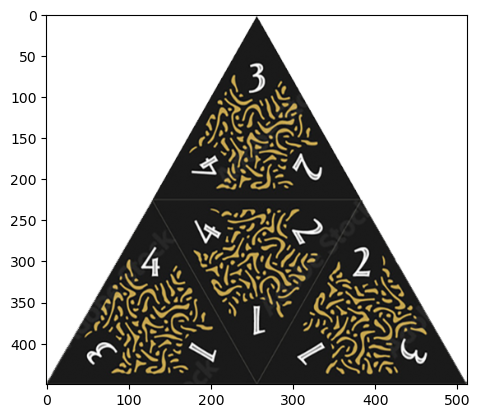

In [3]:
texture_img = cv2.imread('data/d4_texture.png')
texture_img = cv2.cvtColor(texture_img, cv2.COLOR_BGR2RGB) / 255
plt.imshow(texture_img)
plt.show()

Задача: записать
- координаты вершин тетраедра в 3D
- тройки индексов вершин, которые составляют каждую грань в 3D
- uv-координаты вершин тетраедра
- тройки индексов граней в uv-пространстве

Считайте, что длина каждого ребра равна единице

Будьте внимательны: для рендеринга мы будем использовать pytorch3d, в нем u -- это координата по горизонтали, v -- по вертикали. Также v направлена снизу вверх

<img src="data/uvexp.jpg"  width="500">

In [4]:
device = 'cuda:0'

sqrt2 = math.sqrt(2)
sqrt3 = math.sqrt(3)
tetr_h = sqrt2 / sqrt3


verts_3d = np.array(
    [
        # Base 124
        [0, 0, 0],  # 1
        [1, 0, 0],  # 2
        [1/2, sqrt3/2, 0],  # 4

        # Top vertex
        [1/2, sqrt3/6, tetr_h],  # 3
    ]
)

faces_3d = np.array(
    [
        # Base 124
        [0, 1, 2],

        # Side 314
        [3, 0, 2],

        # Side 132
        [0, 3, 1],

        # Side 423
        [2, 1, 3],
    ]
)

verts_2d = np.array(
    [
        # Base 124
        [1/2, 0],  # 1
        [3/4, 1/2],  # 2
        [1/4, 1/2],  # 4

        # Side 314
        [0, 0],  # 3

        # Side 132
        [1, 0],  # 3

        # Side 423
        [1/2, 1],  # 3
    ]

)

faces_2d = np.array(
    [
        # Base 124
        [0, 1, 2],

        # Side 314
        [3, 0, 2],

        # Side 132
        [0, 4, 1],

        # Side 423
        [2, 1, 5],
    ]
).astype(np.int32)

verts_3d = torch.from_numpy(verts_3d.astype(np.float32)).to(device)[None]
faces_3d = torch.from_numpy(faces_3d.astype(np.int32)).to(device)[None]
verts_2d = torch.from_numpy(verts_2d.astype(np.float32)).to(device).contiguous()[None]
faces_2d = torch.from_numpy(faces_2d.astype(np.int32)).to(device)[None]
texture = torch.from_numpy(texture_img.astype(np.float32)).to(device)[None]




Чтобы проверить, отрендерим наш тетраедр:

+ можете изменить параметры `distance`, `elevation` и `azimuth` чтобы отрендерить с разных сторон

In [5]:
dice_mesh = make_mesh(verts_3d, faces_3d, texture, faces_2d, verts_2d)

In [6]:
dist = widgets.FloatSlider(
    value=2.8,
    min=0,
    max=10.0,
    step=0.1,
    description='Distance:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
elev = widgets.IntSlider(0, -180, 180, description='Elevation:')
azim = widgets.IntSlider(0, -180, 180, description='Azimuth:')
ui = widgets.HBox([dist, elev, azim])


def show_model(dist, elev, azim):
    image_ref = render_mesh(dice_mesh, distance=dist, elevation=elev, azimuth=azim)

    image_ref_np = image_ref.cpu().numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(image_ref_np.squeeze())
    plt.grid(False)


display(ui, widgets.interactive_output(show_model, {'dist': dist, 'elev': elev, 'azim': azim}))

Output()

In [7]:
from pytorch3d.io import IO


mesh_dir = 'mesh_result'
os.makedirs(mesh_dir, exist_ok=True)


# Save mesh to validate in CloudCompare or any other program.
mesh = IO().save_mesh(dice_mesh, os.path.join(mesh_dir, "dice_mesh.obj"))

An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/home/egor/mambaforge/envs/diff_rendering/lib/python3.10/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/home/egor/mambaforge/envs/diff_rendering/lib/python3.10/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt


# Задача 2: оптимизация положения камеры

Теперь давайте попробуем, имея 2D картинку объекта, соптимизировать положение камеры относительно объекта используя дифференцируемый рендерер

Для этого будем использовать метод Soft Rendering.

Как целевую картинку будем использовать `image_ref` из предыдущего задания

Шаги
- Создать рендерер и модель используя функцию и класс ниже
- Определить попиксельные loss-функции
    - Заметьте, что у картирок есть 4й альфа-канаЛ, поэтому можно отдельно балансить лосс по RGB и по силуету
- Написать оптимизационный цикл
    - Вожможно, понадобится подобрать расписание learning rate'a
    
Из-за того что объект очень симметричный с очень регулярной формой, может быть сложно достичь идентичной картинки. Постарайтесь как минимум получить силует как на целевой картинке.

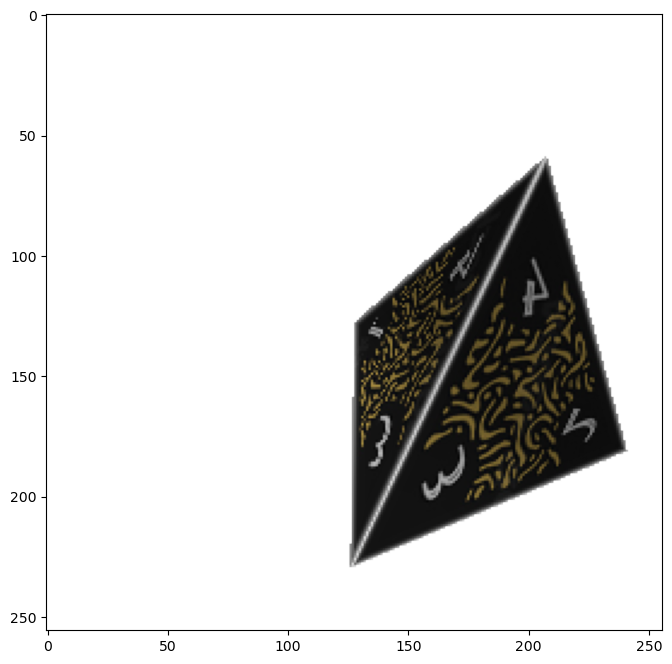

In [8]:
# distance = 1.2  # дистанция от камеры по объекта
# elevation = -26  # в градусах
# azimuth = -110  # в градусах

distance = 2  # дистанция от камеры по объекта
elevation = 49  # в градусах
azimuth = 32  # в градусах

image_ref = render_mesh(dice_mesh, distance=distance, elevation=elevation, azimuth=azimuth)

image_ref_np = image_ref.cpu().numpy()
plt.figure(figsize=(8, 8))
plt.imshow(image_ref_np.squeeze())
plt.grid(False)

In [9]:
def make_soft_rgb_renderer(sigma=1e-4, gamma=1e-4):
    cameras = FoVPerspectiveCameras(device=device)
    blend_params = BlendParams(sigma=sigma, gamma=gamma)

    raster_settings = RasterizationSettings(
        image_size=256,
        blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma,
        faces_per_pixel=100,
    )

    lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
    phong_renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras,
            raster_settings=raster_settings
        ),
        shader=SoftPhongShader(device=device, cameras=cameras, lights=lights)
    )

    return phong_renderer


In [10]:
class Model(nn.Module):
    def __init__(self, meshes, rgb_renderer):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.rgb_renderer = rgb_renderer

        # оптимизируемые параметры
        self.camera_position = nn.Parameter(
            torch.from_numpy(np.array([3.0,  6.9, +2.5], dtype=np.float32)).to(meshes.device))

    def forward(self):

        R = look_at_rotation(self.camera_position[None, :], device=self.device)  # (1, 3, 3)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]   # (1, 3)

        image_rgb = self.rgb_renderer(meshes_world=self.meshes.clone(), R=R, T=T)
        return image_rgb


In [11]:
import math
from functools import partial

from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR


def _get_cosine_schedule_with_warmup_lr_lambda(
    current_step: int, *, num_warmup_steps: int, num_training_steps: int, num_cycles: float
):
    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))
    progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
    return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))


# Implementation from huggingface/transformers.
def get_cosine_schedule_with_warmup(
    optimizer: Optimizer, num_warmup_steps: int, num_training_steps: int, num_cycles: float = 0.5, last_epoch: int = -1
):
    """
    Create a schedule with a learning rate that decreases following the values of the cosine function between the
    initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
    initial lr set in the optimizer.
    Args:
        optimizer ([`~torch.optim.Optimizer`]):
            The optimizer for which to schedule the learning rate.
        num_warmup_steps (`int`):
            The number of steps for the warmup phase.
        num_training_steps (`int`):
            The total number of training steps.
        num_cycles (`float`, *optional*, defaults to 0.5):
            The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
            following a half-cosine).
        last_epoch (`int`, *optional*, defaults to -1):
            The index of the last epoch when resuming training.
    Return:
        `torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """

    lr_lambda = partial(
        _get_cosine_schedule_with_warmup_lr_lambda,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps,
        num_cycles=num_cycles,
    )
    return LambdaLR(optimizer, lr_lambda, last_epoch)


In [12]:
torch.manual_seed(0) 

renderer = make_soft_rgb_renderer(sigma=1e-5)
model = Model(dice_mesh, renderer)

In [13]:
import torch.nn as nn
from tqdm import tqdm



def make_visualizer():
    prev_renders = []

    def plot_rendered_img(model: Model, image_targ: torch.Tensor, title: str):

        image_targ = image_targ.cpu().numpy().squeeze()

        with torch.no_grad():
            image_res = model.forward()
            image_res = image_res.cpu().numpy().squeeze()


        fig = plt.figure(figsize=(14,4))

        # Render
        ax1 = fig.add_subplot(1,4,1)
        ax1.imshow(image_res)

        # Target
        ax2 = fig.add_subplot(1,4,2)
        ax2.imshow(image_targ)

        shiluette_diff = image_res[..., 3] - image_targ[..., 3]

        # Diff between render and target
        ax3 = fig.add_subplot(1,4,3)
        ax3.imshow(shiluette_diff)

        # Diff between renders
        print(f'{len(prev_renders)= }')
        if prev_renders:
            ax4 = fig.add_subplot(1,4,4)
            ax4.imshow(image_res[..., 3] - prev_renders.pop(0)[..., 3])

        plt.title(title)
        plt.show()

        prev_renders.append(image_res)
    return plot_rendered_img


def img_to_silhuette(img: torch.Tensor) -> torch.Tensor:
    with torch.no_grad():
        return torch.from_numpy((img[..., :3].cpu().numpy().squeeze().max(-1) != 1).astype(np.float32)).unsqueeze(0).to(img.device)



def train(
    target_img: torch.Tensor,
    model: Model,
    steps: int = 20000,
    warmup_steps: int = 1000,
    num_cycles: float = 0.5,
    lr: float = 1e-2,
    sh_loss_weight=1.4,
    rgb_loss_weight=0.3,
    plot_every_n_steps=1000,
):
    optimizer = torch.optim.Adam(params=[model.camera_position], lr=lr)
    # optimizer = torch.optim.SGD(params=[model.camera_position], lr=lr, momentum=0.9)

    scheduler = get_cosine_schedule_with_warmup(optimizer, num_training_steps=steps, num_warmup_steps=warmup_steps, num_cycles=num_cycles)
    target_silhuette = img_to_silhuette(target_img)

    visualizer = make_visualizer()

    for step in (pbar := tqdm(range(steps))):
        if step > 0:
            pbar.set_description(f"{step=}, lr={round(scheduler.get_last_lr()[0], 3)} loss={loss.item()}")

        optimizer.zero_grad()

        image_rgb = model()  # (1, w, h, 4)

        silhouette_loss = nn.functional.mse_loss(target_silhuette, image_rgb[..., 3])
        rgb_loss = nn.functional.mse_loss(target_img[:,:,:,:3], image_rgb[:,:,:,:3])

        rgb_loss_warmup_factor = 1 # np.clip(step / warmup_steps, 0.05, 1)
        loss = (
            sh_loss_weight * silhouette_loss + rgb_loss_weight * rgb_loss_warmup_factor * rgb_loss
        )
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(model.camera_position, max_norm=10)
        optimizer.step()
        scheduler.step()

        if step % plot_every_n_steps == 0:
            visualizer(model, target_img, title=f'{step=}')

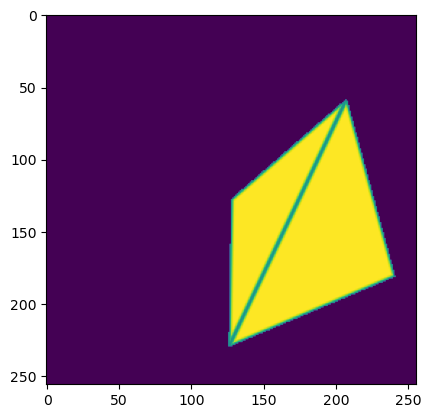

In [14]:
plt.imshow(image_ref[..., 3].cpu().numpy().squeeze())

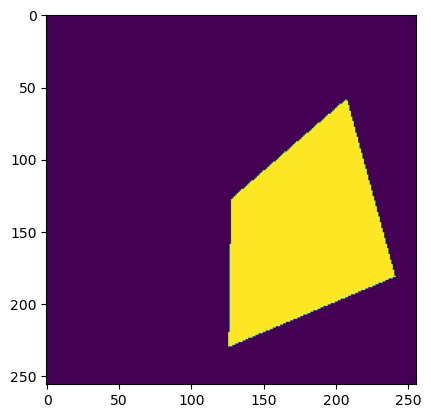

In [15]:
masked = torch.from_numpy((image_ref[..., :3].cpu().numpy().squeeze().max(-1) != 1).astype(np.float32))
plt.imshow(masked.cpu().numpy().squeeze())

  0%|                                                                                                                       | 0/3000 [00:00<?, ?it/s]

len(prev_renders)= 0


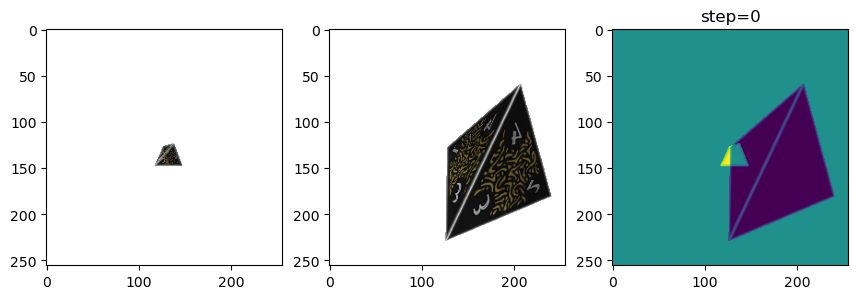

step=500, lr=0.005 loss=0.27750110626220703:  17%|██████████▋                                                     | 500/3000 [01:10<05:51,  7.12it/s]

len(prev_renders)= 1


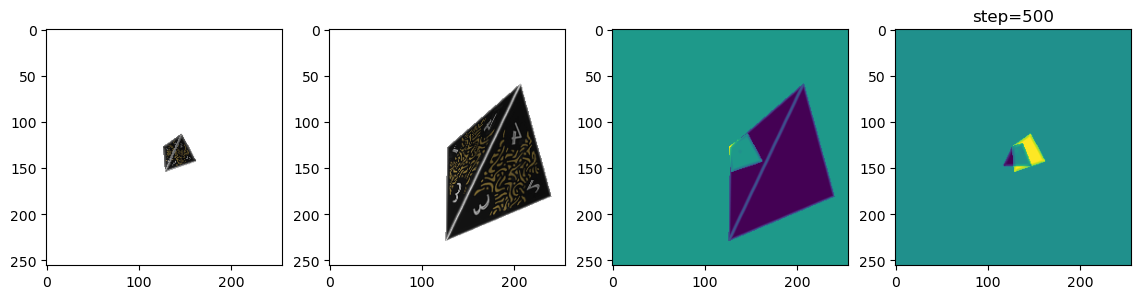

step=1000, lr=0.01 loss=0.0046821050345897675:  33%|████████████████████▎                                        | 1000/3000 [02:21<04:40,  7.13it/s]

len(prev_renders)= 1


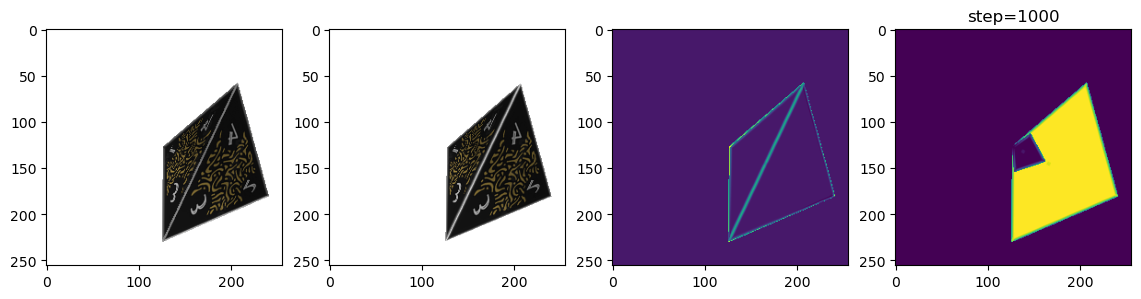

step=1500, lr=0.009 loss=0.004667401313781738:  50%|██████████████████████████████▌                              | 1500/3000 [03:32<03:30,  7.13it/s]

len(prev_renders)= 1


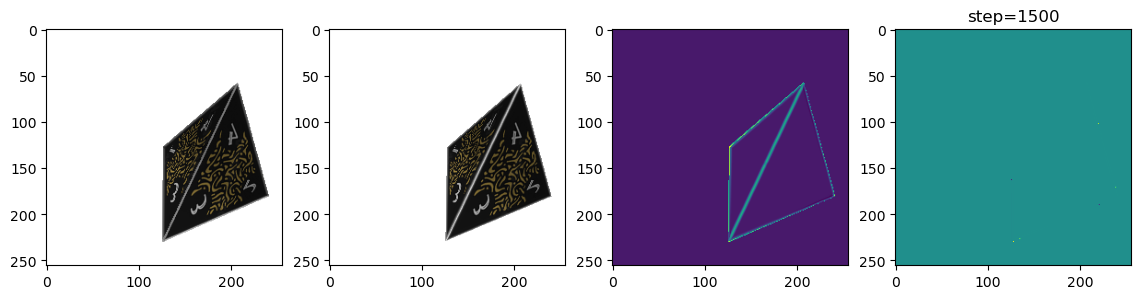

step=2000, lr=0.005 loss=0.004667222034186125:  67%|████████████████████████████████████████▋                    | 2000/3000 [04:42<02:20,  7.12it/s]

len(prev_renders)= 1


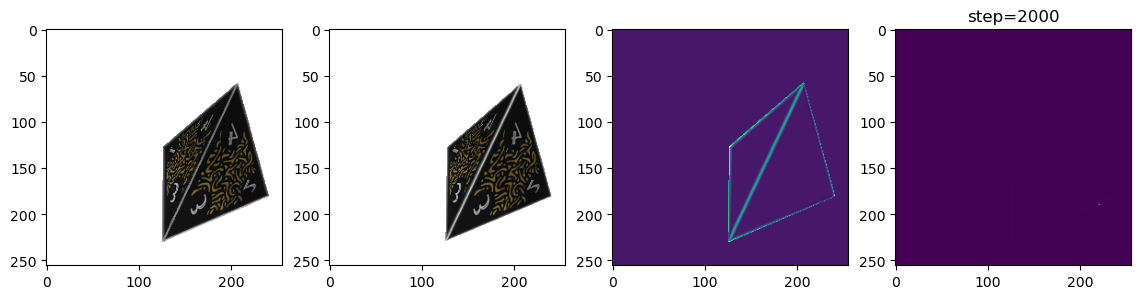

step=2500, lr=0.001 loss=0.004682209342718124:  83%|██████████████████████████████████████████████████▊          | 2500/3000 [05:53<01:10,  7.14it/s]

len(prev_renders)= 1


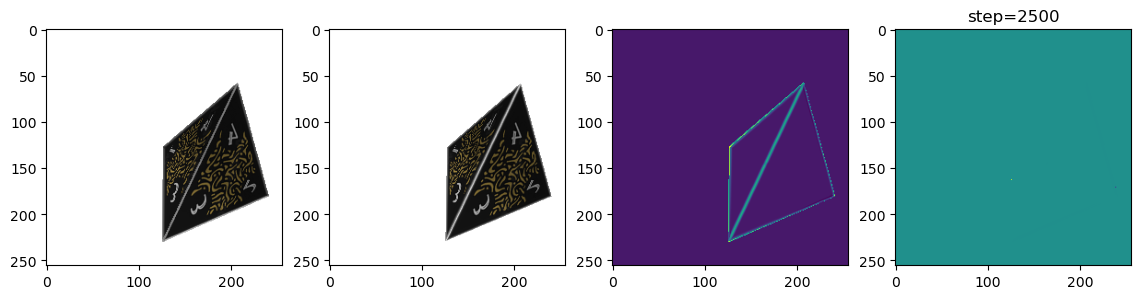

step=2999, lr=0.0 loss=0.004676174838095903: 100%|███████████████████████████████████████████████████████████████| 3000/3000 [07:03<00:00,  7.08it/s]


In [16]:
train(image_ref, model, steps=3000, plot_every_n_steps=500)

# image_res.shape

# Задание 3 (со звёздочкой): нейронные текстуры

- Склоньте репозиторий [Neural Textures](https://github.com/Dolorousrtur/neural-textures)
- По инструкции в README.md постройте докер контейнер и скачайте данные
- Используя код из `render_azure_person.py` и `utils/demo.py` в ноутбуке
    - достаньте пресохранённую нейронную текстуру (см. `utils/demo.py:L101`)
    - отрисуйте её первые 3 канала
    - Затем сделайте нейронный рендер (см. `utils/demo.py:L99,107`) и тоже отрисуйте его первые 3 канала
    - Пропустите нейрорендер сквозб рендерющую сеть, чтобы получить RGB картинку `utils/demo.py:L99,107`)